In [1]:
import git
import sys
import os
sys.path.append("../python")
sys.path.append(os.path.join(os.environ["ALSVINN_BUILD_PATH"], "python"))


import alsvinn
import numpy as np
import plot_info
import matplotlib.pyplot as plt

# The sample solution will be generated at SAMPLE_SOLUTION_FACTOR*highest_resolution_in_convergence
SAMPLE_SOLUTION_FACTOR=int(os.environ.get("FVM_TV_CONVERGENCE_SAMPLE_SOLUTION_FACTOR", 32))

# This should be the highest resolution you can afford to run one sample of (or 50 samples rather)
# MUST BE A POWER OF 2
COMPUTATIONAL_BUDGET=int(os.environ.get("FVM_TV_CONVERGENCE_COMPUTATIONAL_BUDGET", 2**15))

# This should be the highest resolution you can afford to run one sample with t=0
# MUST BE A POWER OF 2
COMPUTATIONAL_T0_BUDGET=int(os.environ.get("FVM_TV_CONVERGENCE_COMPUTATIONAL_T0_BUDGET", 2**15))

# Number of samples for uq runs
NUMBER_OF_SAMPLES=int(os.environ.get("FVM_TV_CONVERGENCE_NUMBER_OF_SAMPLES", 512))

#################################################################################################

# Highest single resolution for deterministic convergence
CONVERGENCE_DET_HIGHEST_RESOLUTION=int(COMPUTATIONAL_BUDGET/SAMPLE_SOLUTION_FACTOR)

# Highest single resolution for uq convergence (we estimate the runtime)
CONVERGENCE_UQ_HIGHEST_RESOLUTION=2**int(np.log2(COMPUTATIONAL_BUDGET/(SAMPLE_SOLUTION_FACTOR)/(np.sqrt(NUMBER_OF_SAMPLES))))


START_CONVERGENCE_DET_LOG=int(max(2, int(np.log2(CONVERGENCE_DET_HIGHEST_RESOLUTION))-7))
END_CONVERGENCE_DET_LOG=int(np.log2(CONVERGENCE_DET_HIGHEST_RESOLUTION))

START_CONVERGENCE_UQ_LOG=int(max(2, int(np.log2(CONVERGENCE_UQ_HIGHEST_RESOLUTION))-7))
END_CONVERGENCE_UQ_LOG=int(np.log2(CONVERGENCE_UQ_HIGHEST_RESOLUTION))

HIGHEST_RESOLUTION_UQ_T0 = 2**int(np.log2(COMPUTATIONAL_T0_BUDGET/np.sqrt(NUMBER_OF_SAMPLES)))

START_CAUCHY_UQ_T0_LOG=int(max(2, int(np.log2(HIGHEST_RESOLUTION_UQ_T0))-7))
END_CAUCHY_UQ_T0_LOG=int(np.log2(HIGHEST_RESOLUTION_UQ_T0))

START_CAUCHY_DET_T0_LOG=int(max(2, int(np.log2(COMPUTATIONAL_T0_BUDGET))-7))
END_CAUCHY_DET_T0_LOG=int(np.log2(COMPUTATIONAL_T0_BUDGET))




plot_info.console_log_show("SAMPLE_SOLUTION_FACTOR={}".format(SAMPLE_SOLUTION_FACTOR))
plot_info.console_log_show("COMPUTATIONAL_BUDGET={}".format(COMPUTATIONAL_BUDGET))
plot_info.console_log_show("COMPUTATIONAL_T0_BUDGET={}".format(COMPUTATIONAL_T0_BUDGET))
plot_info.console_log_show("NUMBER_OF_SAMPLES={}".format(NUMBER_OF_SAMPLES))
plot_info.console_log_show("CONVERGENCE_DET_HIGHEST_RESOLUTION={}".format(CONVERGENCE_DET_HIGHEST_RESOLUTION))
plot_info.console_log_show("CONVERGENCE_UQ_HIGHEST_RESOLUTION={}".format(CONVERGENCE_UQ_HIGHEST_RESOLUTION))
plot_info.console_log_show("START_CONVERGENCE_DET_LOG={}".format(START_CONVERGENCE_DET_LOG))
plot_info.console_log_show("END_CONVERGENCE_DET_LOG={}".format(END_CONVERGENCE_DET_LOG))
plot_info.console_log_show("START_CONVERGENCE_UQ_LOG={}".format(START_CONVERGENCE_UQ_LOG))
plot_info.console_log_show("END_CONVERGENCE_UQ_LOG={}".format(END_CONVERGENCE_UQ_LOG))
plot_info.console_log_show("HIGHEST_RESOLUTION_UQ_T0={}".format(HIGHEST_RESOLUTION_UQ_T0))
plot_info.console_log_show("START_CAUCHY_UQ_T0_LOG={}".format(START_CAUCHY_UQ_T0_LOG))
plot_info.console_log_show("END_CAUCHY_UQ_T0_LOG={}".format(END_CAUCHY_UQ_T0_LOG))
plot_info.console_log_show("START_CAUCHY_DET_T0_LOG={}".format(START_CAUCHY_DET_T0_LOG))
plot_info.console_log_show("END_CAUCHY_DET_T0_LOG={}".format(END_CAUCHY_DET_T0_LOG))

alsvinn_repo = git.Repo(path=os.environ["ALSVINN_BUILD_PATH"], search_parent_directories=True)

alsvinn_commit_sha = alsvinn_repo.head.object.hexsha
alsvinn_short_commit_sha =  alsvinn_repo.git.rev_parse(alsvinn_commit_sha, short=1)

plot_info.set_alsvinn_sha(alsvinn_commit_sha, alsvinn_short_commit_sha)

SyntaxError: invalid syntax (<ipython-input-1-3131f30a6667>, line 69)

In [2]:
class ExactLinearSolution(object):
    def __init__(self, initial_data):
        self.initial_data = np.copy(np.array(initial_data))
        self.x, self.dx = np.linspace(0, 1, initial_data.shape[0], retstep=True)
        
    def __call__(self, t):
        x_shift = int(t/self.dx)

        u = np.roll(np.copy(self.initial_data), x_shift)
        
        return u
    

In [3]:
equations = ["burgers", "cubic", "linear"]

numerical_fluxes = {}

numerical_fluxes["burgers"] = ["rusanov", "godunov", "roe"]
numerical_fluxes["linear"] = ["rusanov", "upwind"]
numerical_fluxes["cubic"] = ["rusanov", "roe"]

exact_solutions = {}
exact_solutions["burgers"] = None
exact_solutions["linear"] = ExactLinearSolution
exact_solutions["cubic"] = None

def run_all_configurations(function_to_call, T):
    for equation in equations:
        plot_info.display(plot_info.HTML("<h1>{}<h1>".format(equation)))
        for numerical_flux in numerical_fluxes[equation]:
            plot_info.display(plot_info.HTML("<h2>{}<h2>".format(numerical_flux)))
            
            function_to_call(equation, numerical_flux, exact_solutions[equation], T)

# Convergence runs

In [24]:
def run_convergence(base_xml, title, T, 
                    exact_solution_class=None,
                    numerical_flux="rusanov",
                    equation="burgers"):
    resolutions = 2**np.arange(START_CONVERGENCE_DET_LOG, END_CONVERGENCE_DET_LOG)
    errors = []
    
    
    
    ## Make sample solution
    sample_solution_run = alsvinn.run(name="sample_solution",
        base_xml=base_xml,
        number_of_saves=1,
        dimension=[SAMPLE_SOLUTION_FACTOR*resolutions[-1],1,1],
        flux=numerical_flux,
        equation=equation,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    if exact_solution_class is None:
        sample_solution = sample_solution_run.get_data("u", 1)
    else:
        initial_data = sample_solution_run.get_data("u", 0)

        exact_solution_object = exact_solution_class(initial_data)
        
        sample_solution = exact_solution_object(T)
        
    r_sample = sample_solution.shape[0]
    
    
    ## Loop over resolutions
    for r in resolutions:
        ## Just some progress output, can be deleted
        sys.stdout.write("Resolution = {}\r".format(r))
        sys.stdout.flush()
        
        ## This is where we run alsvinn for the given resolution
        run = alsvinn.run(name="convergence_run",
                         base_xml=base_xml,
                         number_of_saves=1,
                         dimension=[r,1,1],
                         flux=numerical_flux,
                         equation=equation,
                         uq=True, # notice that since we have Brownian initial data, we need to enable uq
                         T=T)
        
        u_approx = run.get_data("u", 1)
        
        u_approx_upscaled = np.repeat(u_approx, r_sample//r)
        
        ## Compute L^1 error
        errors.append(np.sum(abs(u_approx_upscaled-sample_solution))/r_sample)
        
    errors = np.array(errors)
    sys.stdout.write("\r")
    plt.figure(0)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.loglog(resolutions, errors, '-o',basex=2, basey=2,
                           label=title)
    plt.grid(True)
    
    poly = np.polyfit(np.log(resolutions), np.log(errors), 1)
    plt.loglog(resolutions, np.exp(poly[1])*resolutions**poly[0], '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(M^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    
    
    plt.xlabel("Number of cells ($M$)")
    plt.ylabel("Error ($||\\cdot||_{L^1([0,1])}$)")
    plt.legend()
    
    
    plt.figure(1)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.loglog(1.0/resolutions, errors, '-o',basex=2, basey=2,
                           label=title)
    plt.grid(True)
    
    poly = np.polyfit(np.log(1.0/resolutions), np.log(errors), 1)
    plt.loglog(1.0/resolutions, np.exp(poly[1])*resolutions**(-poly[0]), '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(\\Delta x^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    plt.xlabel("$\\Delta x$")
    plt.ylabel("Error ($||\\cdot||_{L^1([0,1])}$)")
    plt.legend()
    
    
    plt.figure(2)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.loglog(1.0/resolutions, errors, '-o',basex=2, basey=2,
                           label=title)
    plt.grid(True)
    
    poly = np.polyfit(np.log(1.0/resolutions), np.log(-errors/np.log(1/resolutions)), 1)
    plt.loglog(1.0/resolutions, -np.log(1/resolutions)*np.exp(poly[1])*resolutions**(-poly[0]), '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(-\\log(\\Delta x)\\Delta x^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    plt.xlabel("$\\Delta x$")
    plt.ylabel("Error ($||\\cdot||_{L^1([0,1])}$)")
    plt.legend()
   
    plot_info.console_log_show("Done configuration {} {} {} {}".format(base_xml, equation, numerical_flux, T))
        
        

# Sanity check with sine initial data



In [25]:
def run_sine_convergence(equation, numerical_flux, exact_solution, T):
    base_xml_format_string = '../configs/sine/sine.xml'



    base_xml = base_xml_format_string
     
    name = "sine intial data"
    run_convergence(base_xml, name, T, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
    
    plt.figure(0)
    plt.title("Convergence plot\n, Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation, numerical_flux=numerical_flux, T=T))

    plt.figure(1)
    plt.title("Convergence plot\n, Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation, numerical_flux=numerical_flux, T=T))
    
    plt.figure(2)
    plt.title("Convergence plot\n, Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation, numerical_flux=numerical_flux, T=T))
    
    plt.show()

    
run_all_configurations(run_sine_convergence, 0.25)
plot_info.console_log_show("Done with sine")
        
        

KeyboardInterrupt: 

# Convergence runs for fBm

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

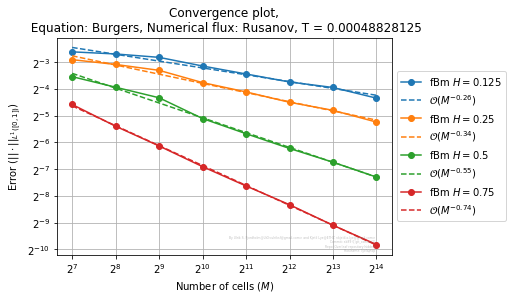

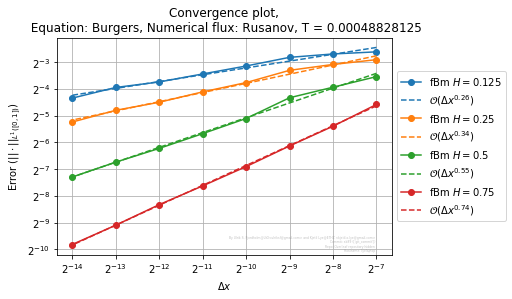

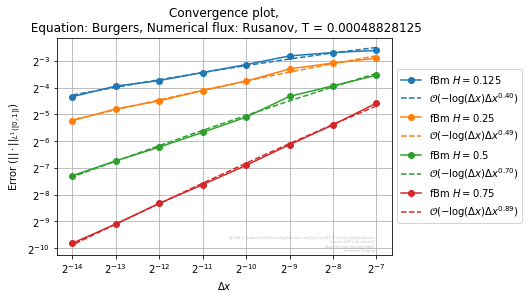

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

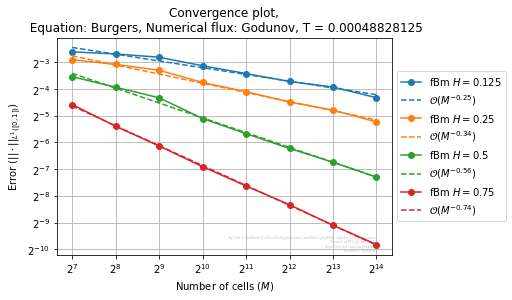

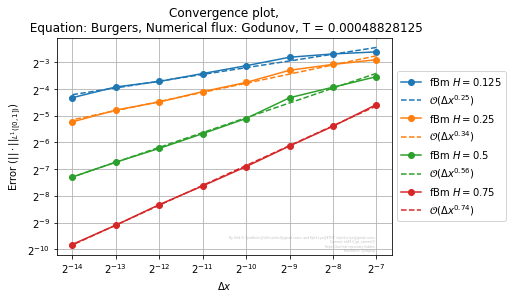

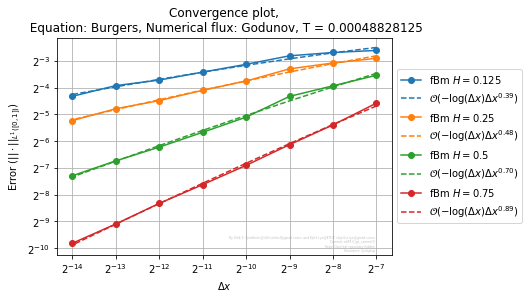

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

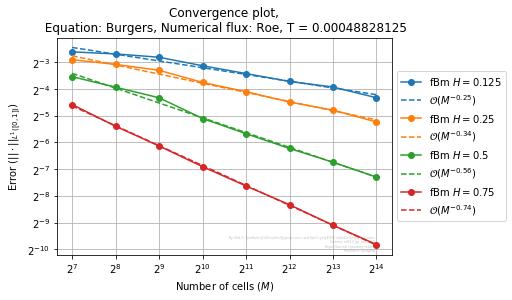

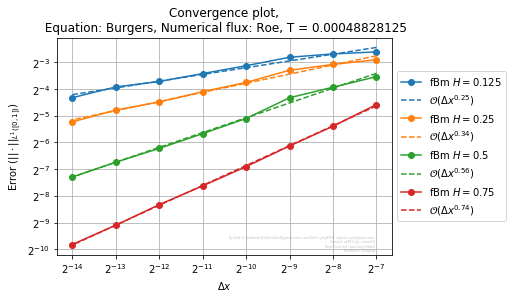

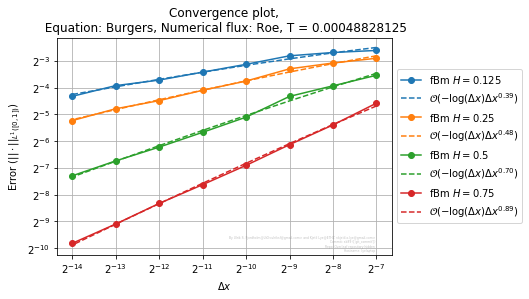

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

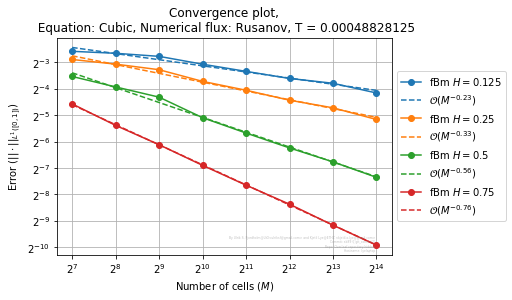

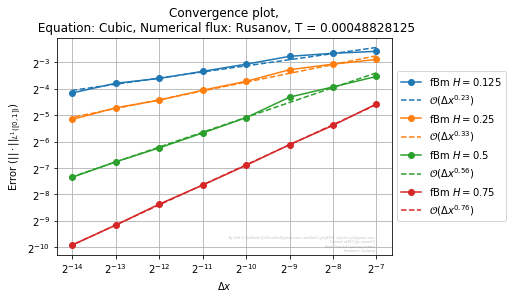

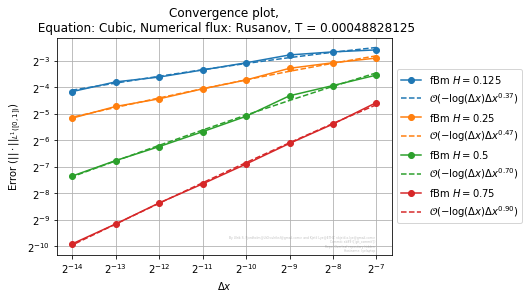

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

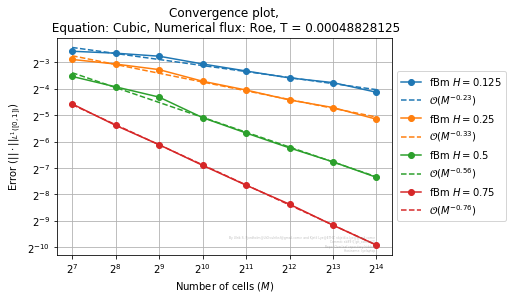

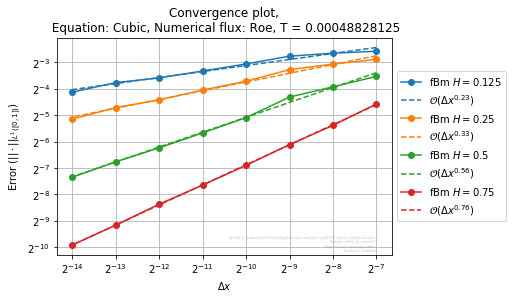

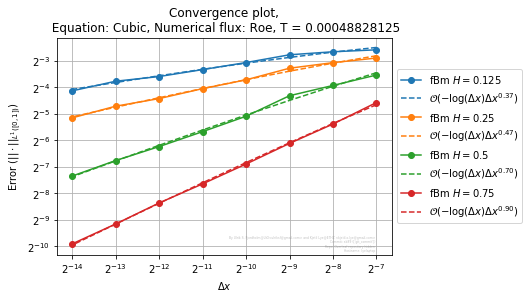

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

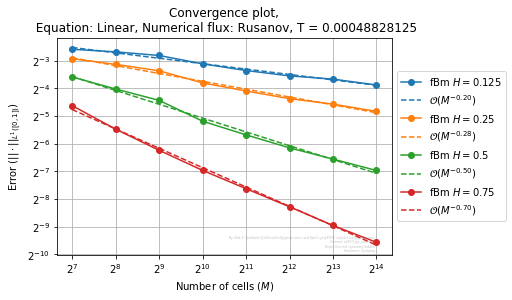

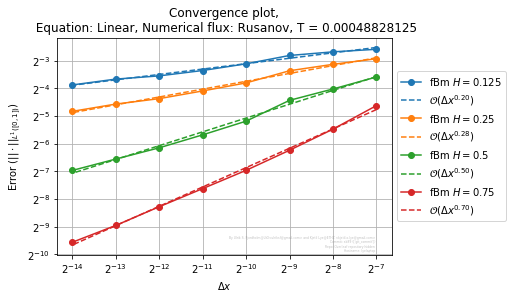

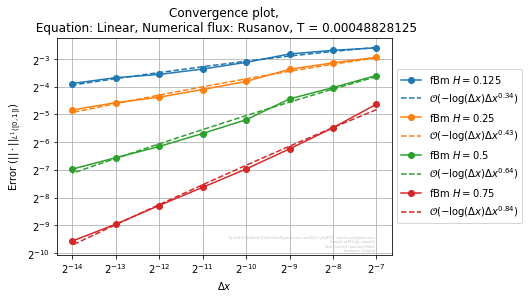

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

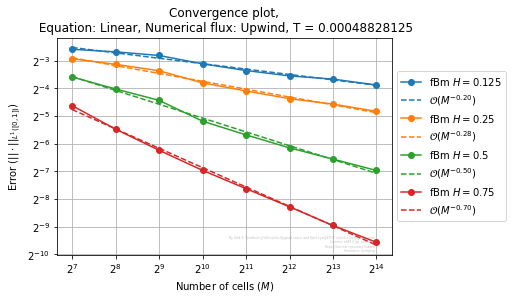

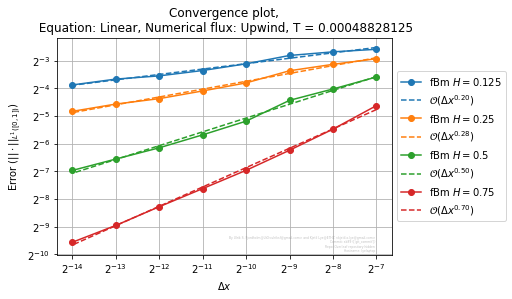

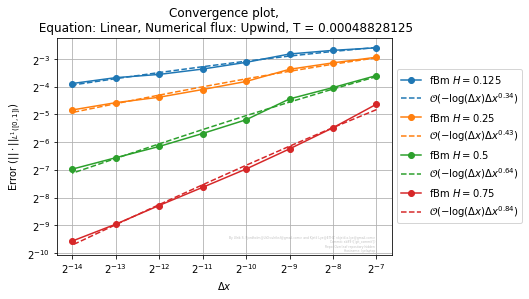

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

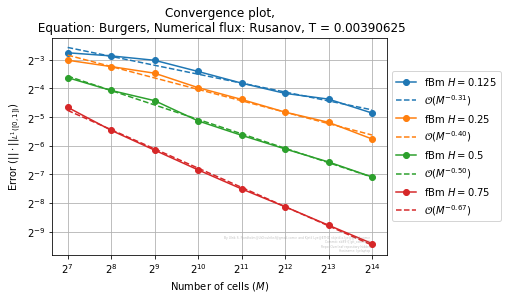

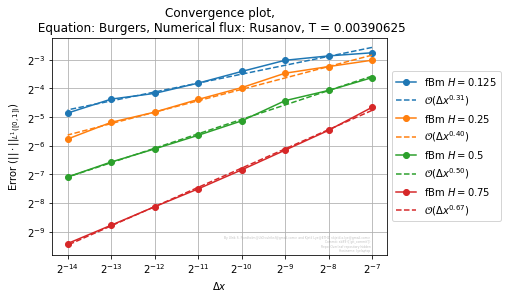

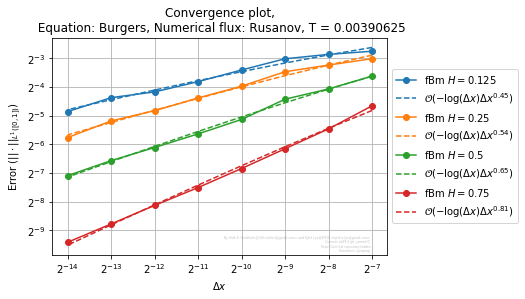

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

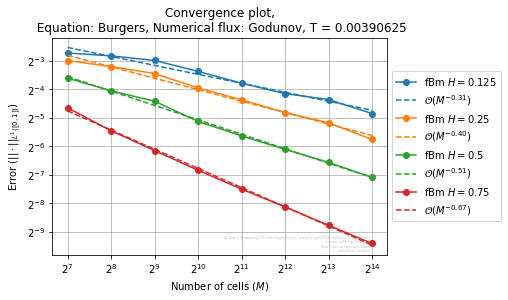

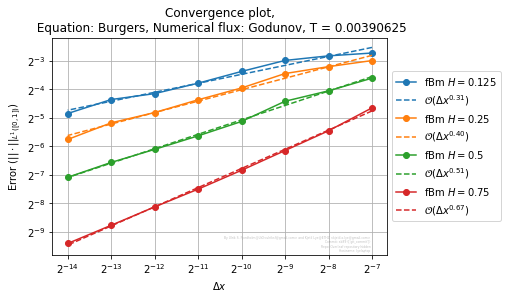

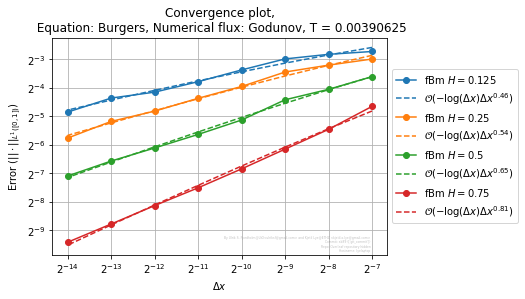

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

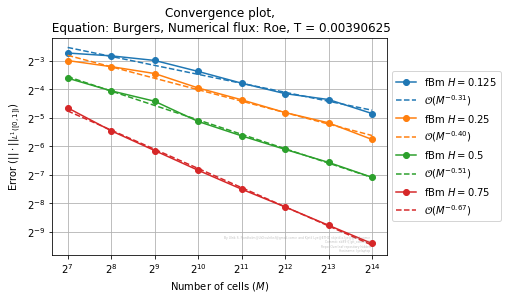

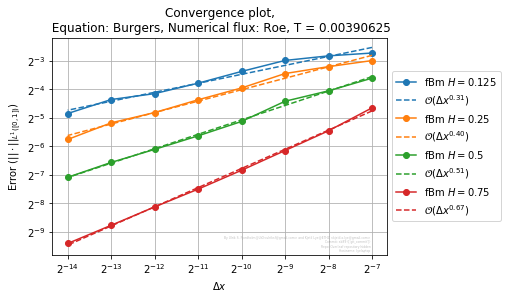

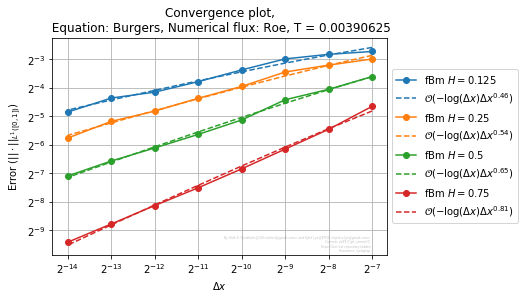

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

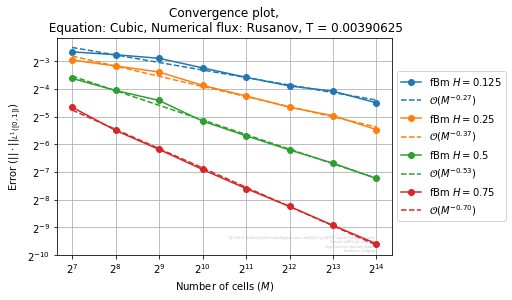

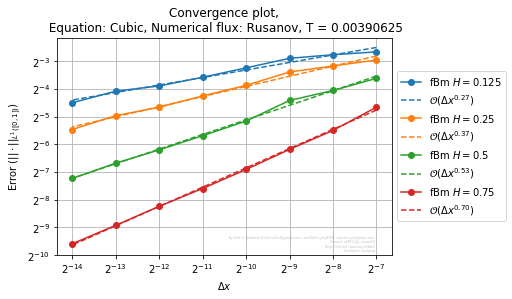

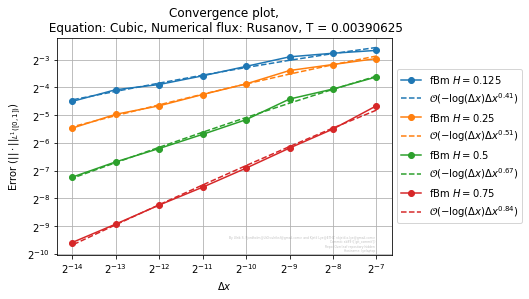

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

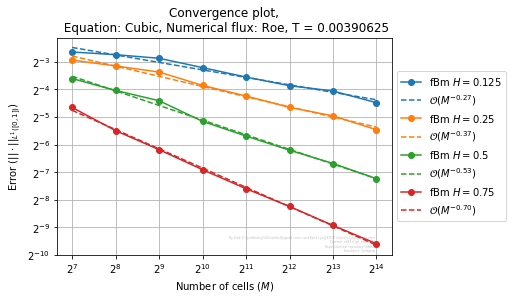

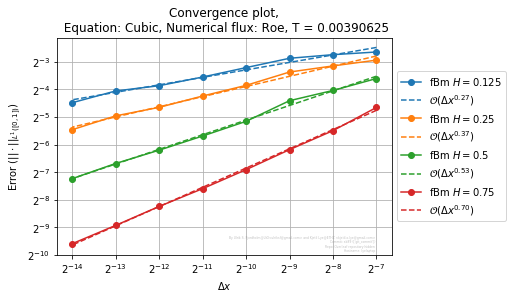

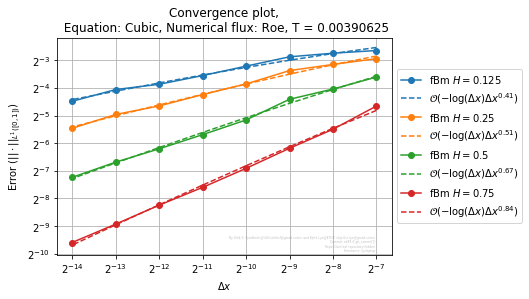

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

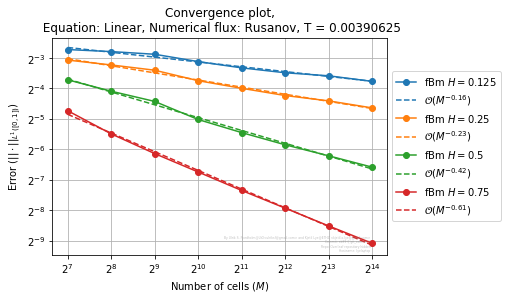

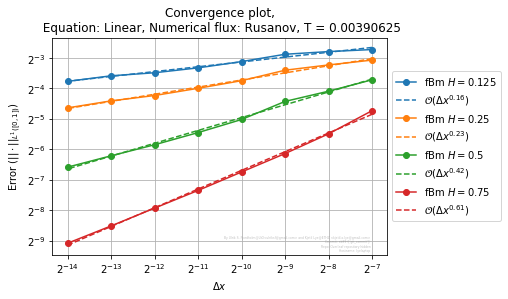

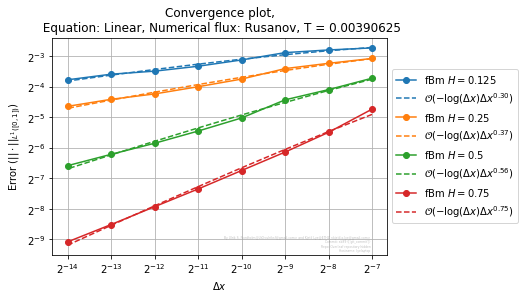

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

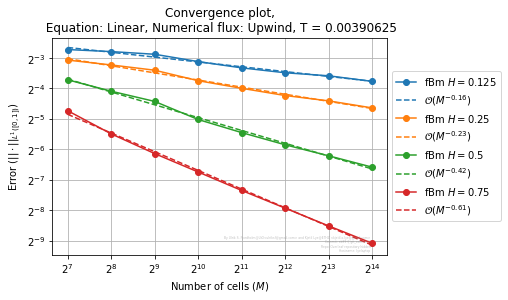

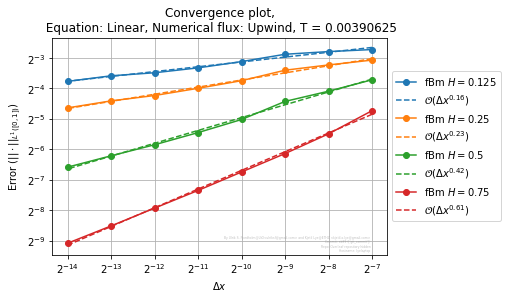

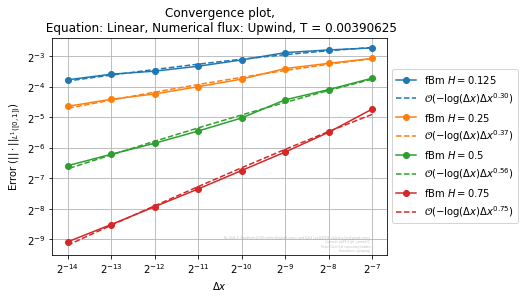

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

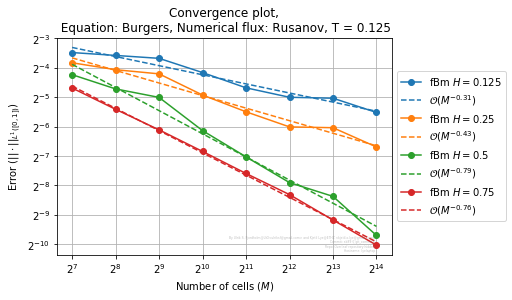

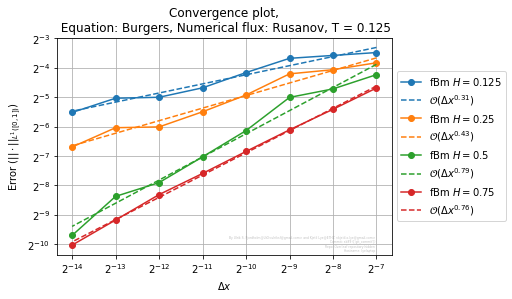

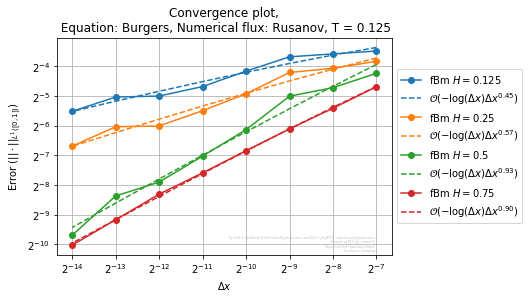

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

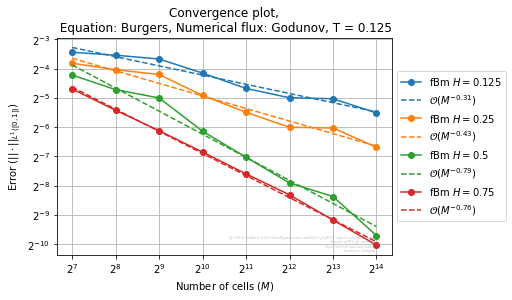

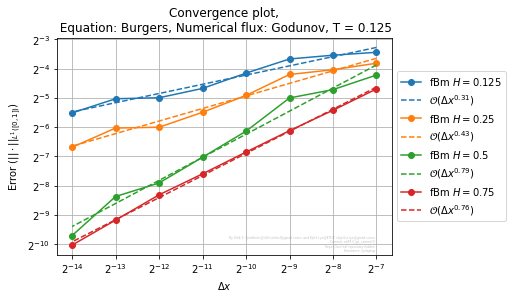

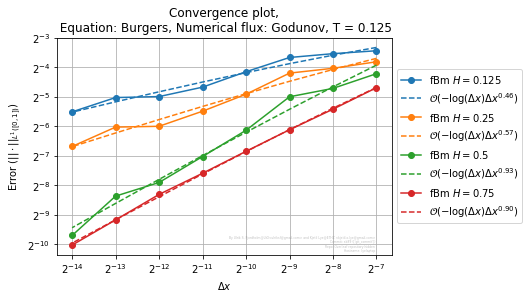

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

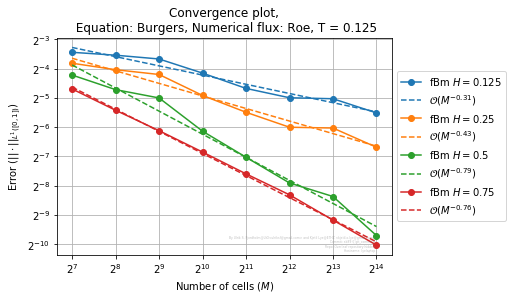

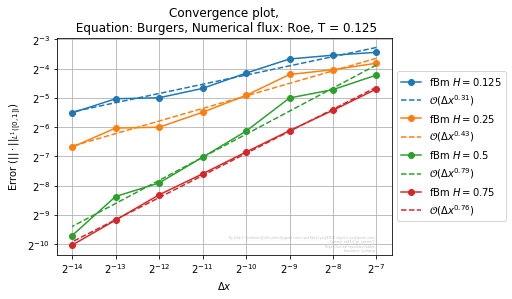

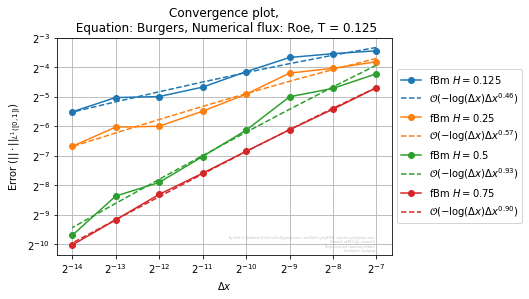

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

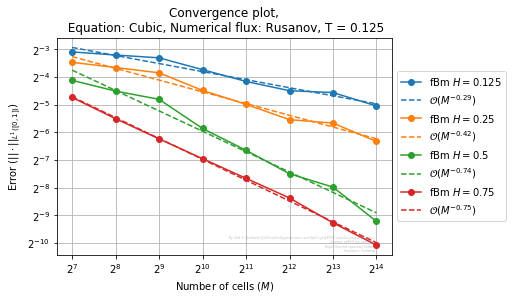

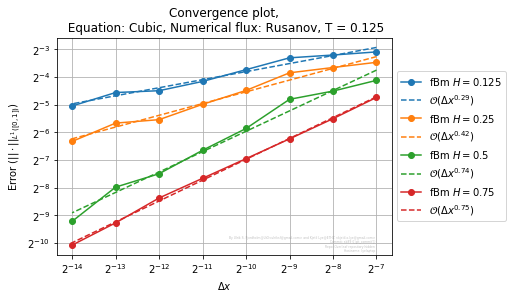

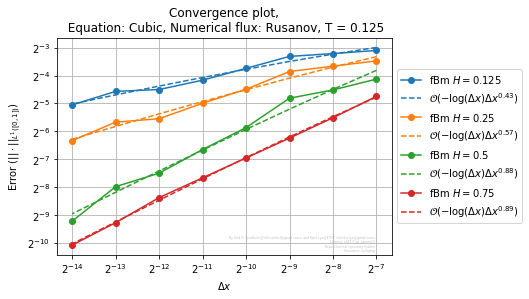

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

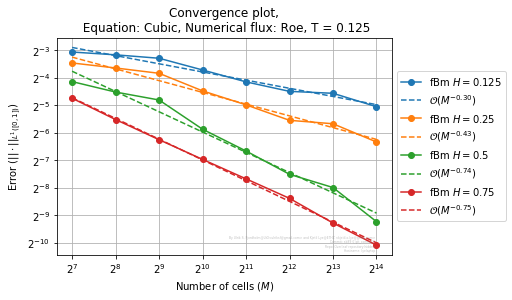

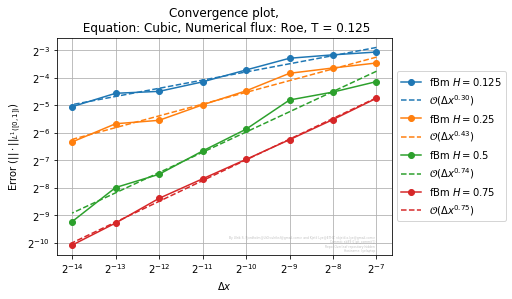

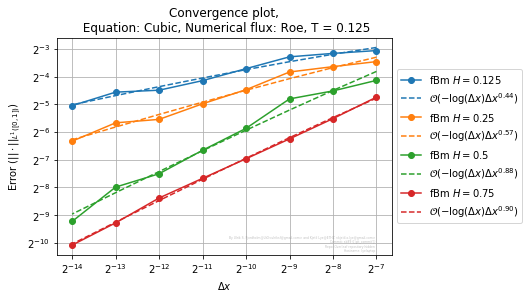

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

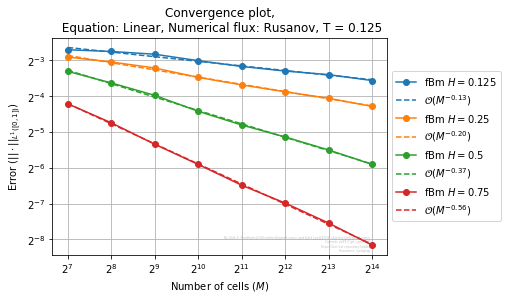

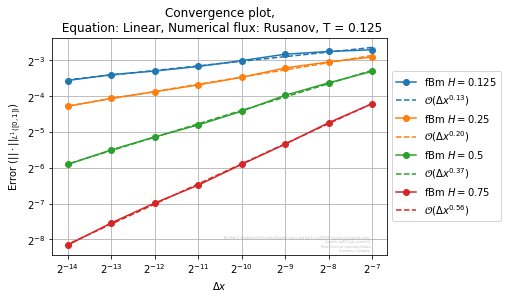

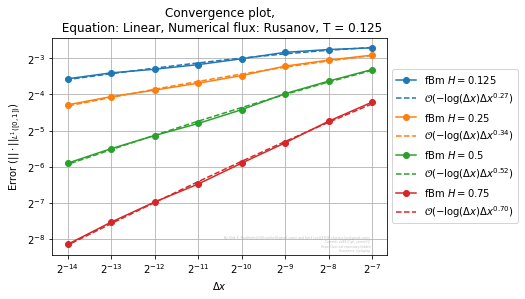

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

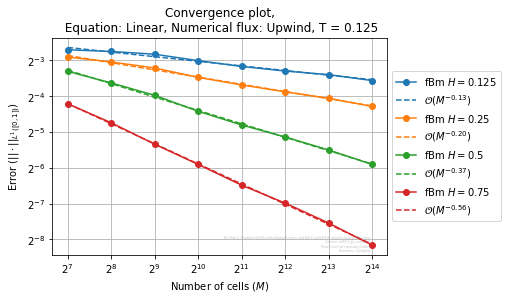

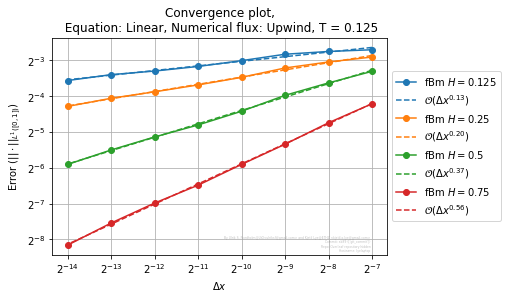

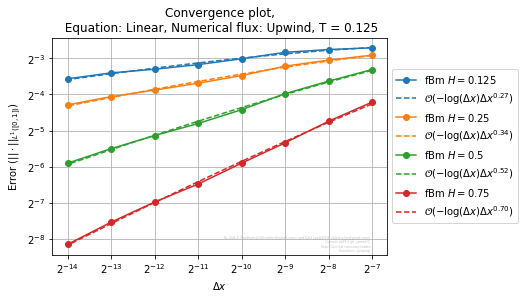

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

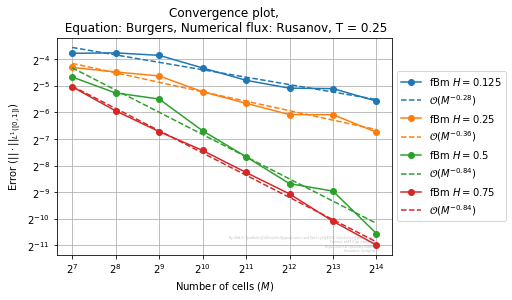

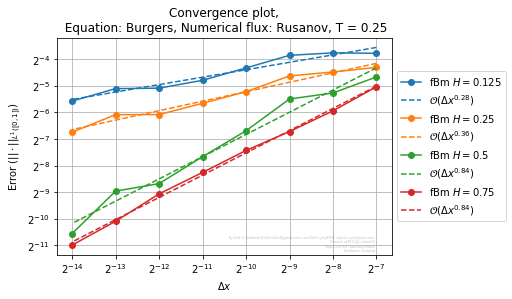

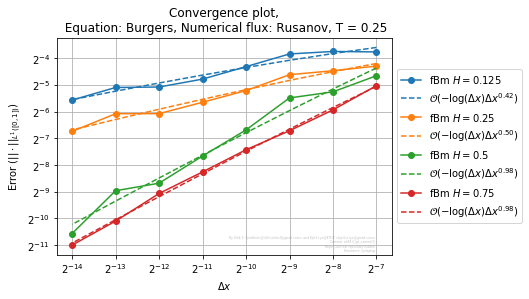

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

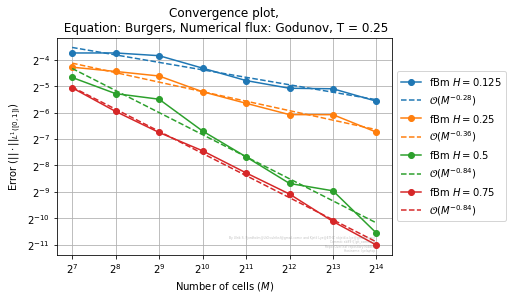

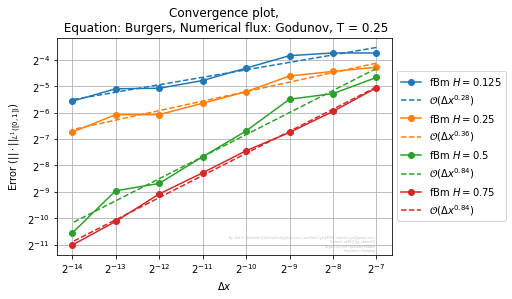

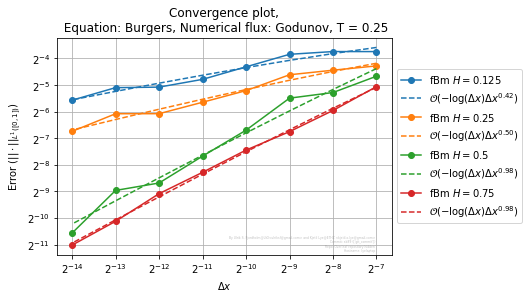

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

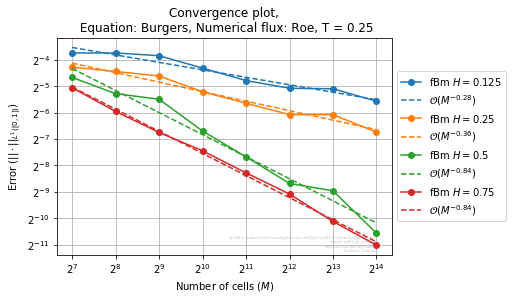

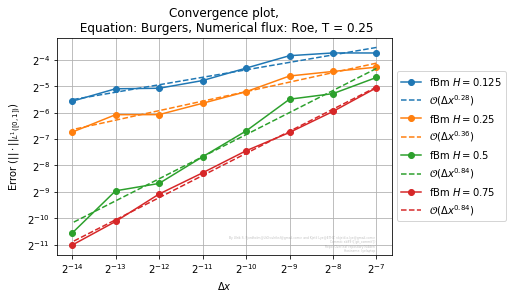

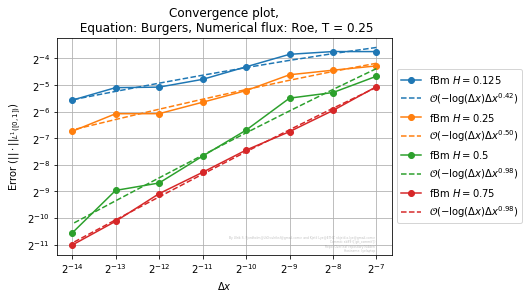

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

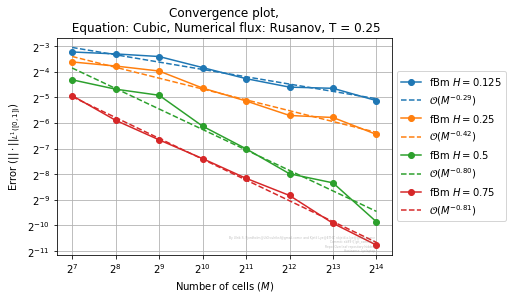

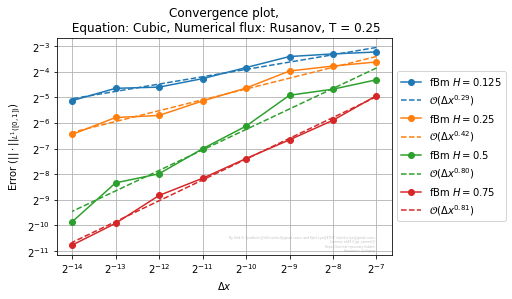

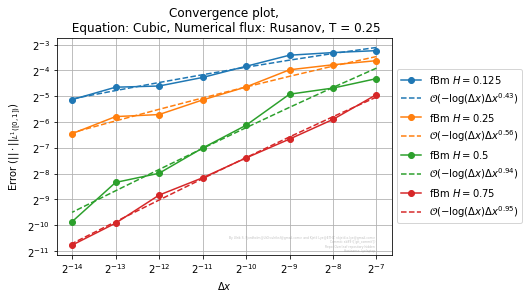

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

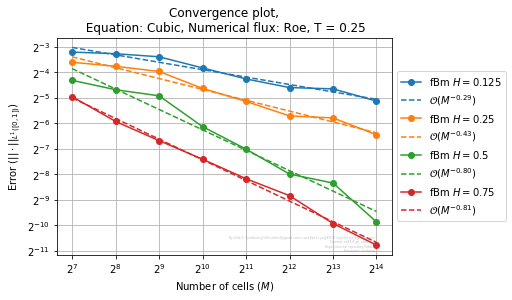

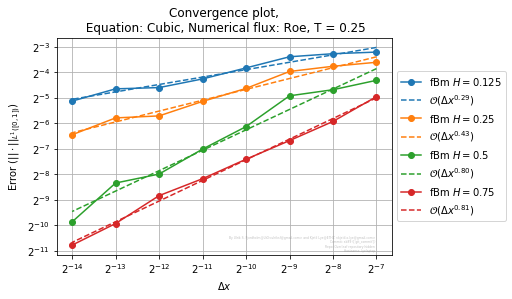

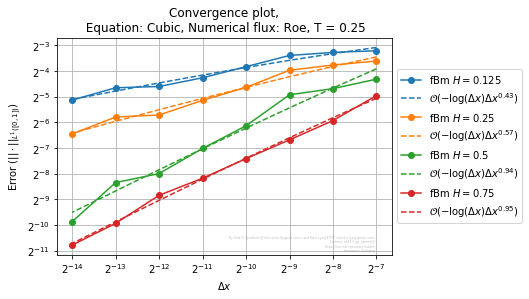

Resolution = 16384Resolution = 128Resolution = 128Resolution = 128

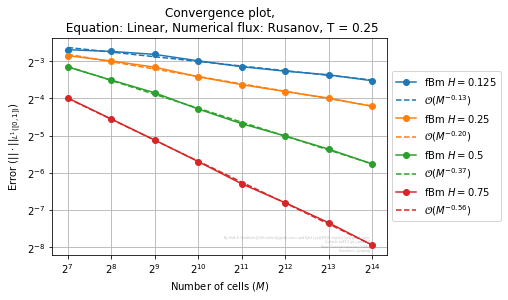

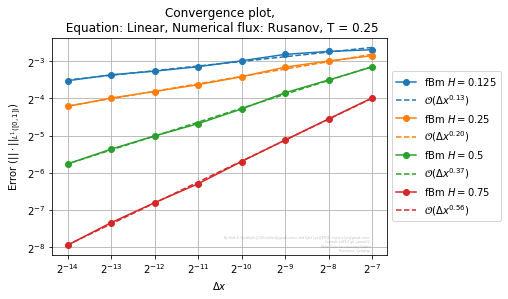

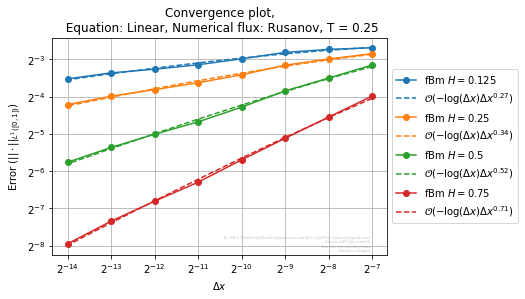

Resolution = 16384Resolution = 128Resolution = 128

KeyboardInterrupt: 

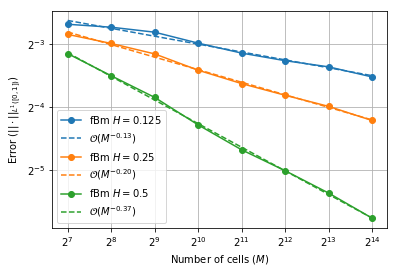

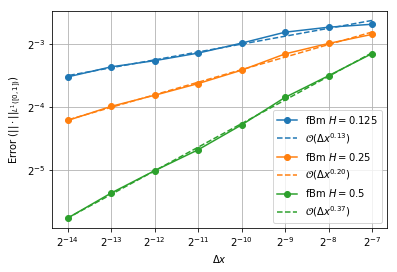

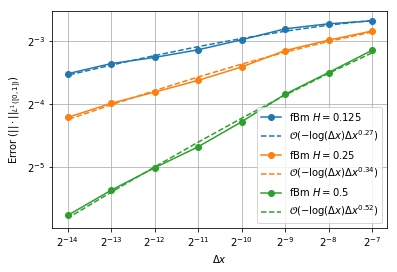

In [6]:
def run_fbm_convergence(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

   
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        run_convergence(base_xml, name, T, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
        
    plt.figure(0)
    plt.title("Convergence plot,\n Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_convergence_M_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    
    plt.figure(1)
    plt.title("Convergence plot,\n Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_convergence_dx_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    
    plt.figure(2)
    plt.title("Convergence plot,\n Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_convergence_log_dx_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    plt.show()
    
for T in [1/2048., 1/256., 1/8, 1.0/4, 1]:
    run_all_configurations(run_fbm_convergence, T)
                                             

# TV over time

In [ ]:
def TV_versus_time(base_xml, title, T, 
                    exact_solution_class=None,
                    numerical_flux="rusanov",
                    equation="burgers"):
    plot_info.console_log_show("Running TV versus time for {}, T={}".format(base_xml, T))
    N = 128
    M = COMPUTATIONAL_BUDGET//N
    
    run = alsvinn.run(name="TV_solution",
        base_xml=base_xml,
        number_of_saves=N,
        dimension=[M,1,1],
        flux=numerical_flux,
        equation=equation,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    TVs = []
    Ts = np.linspace(0,T,N)
    for t_index in range(N):
        u = run.get_data("u", t_index)
        
        tv_u = np.sum(abs(np.diff(u)))
        TVs.append(tv_u)
    TVs = np.array(TVs)
    
    poly = np.polyfit(Ts[1:], 1.0/TVs[1:], 1)
    
    print(poly)
    
    line_info = plt.plot(Ts, 1.0/TVs, label=title)
    
    plt.plot(Ts[1:], poly[0]*Ts[1:]+poly[1],
             '--',
             color=line_info[0].get_color(),
             label='$%.3f t %+.3f$' % (poly[0], poly[1]))
    plt.title("T = {}".format(T))
    plot_info.legendLeft()
    plt.xlabel("$t$")
    plt.ylabel("$\\left(\\mathrm{TV}(u(\\cdot, t)\\right)^{-1}$")


In [ ]:
def run_fbm_tv(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

   
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        TV_versus_time(base_xml, name, T, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
    plt.title("Inverse of Total variation over time,\nEquation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.showAndSave("fbm_tv_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
T = 0.5
run_all_configurations(run_fbm_tv, T)
                                             

# Plotting solutions at single times

In [ ]:
def plot_solution(base_xml, title, T, M, 
                exact_solution_class=None,
                numerical_flux="rusanov",
                equation="burgers"):
    
    plot_info.console_log_show("Running plot solution for {}, T={}, flux={}, equation={}".format(base_xml,
                                                                                                 T,
                                                                                                numerical_flux,
                                                                                                equation))

    
    run = alsvinn.run(name="TV_solution",
        base_xml=base_xml,
        number_of_saves=1,
        dimension=[M,1,1],
        flux=numerical_flux,
        equation=equation,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    
    t_indices = [0, 1]
    ts = [0, T]
    for t_index in t_indices:
        t = ts[t_index]
        u = run.get_data("u", t_index)
        x = np.linspace(0, 1, u.shape[0])
        
        plt.figure(t_index)
        plt.plot(x, u)
        plt.xlabel("$x$")
        plt.ylabel("$u(x,{})$".format(t))
        

In [ ]:
def run_fbm_plot(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

    N = COMPUTATIONAL_BUDGET
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        plot_solution(base_xml, name, T, N, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
        plt.figure(0)
        plt.title("Initial data, fBm with $H={hurz}$\nEquation: {equation}, Numerical flux: {numerical_flux}, Cells: {N}"\
              .format(hurz=H, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), N=N))
        
        plot_info.savePlot("fbm_initial_{equation}_{H}_{numerical_flux}"
                .format(equation=equation, H=str(H).replace(".", "_"), numerical_flux=numerical_flux))
        
        plt.figure(1)
        plt.title("Evolved data at $T={T}$, initial data fBm with $H={hurz}$\nEquation: {equation}, Numerical flux: {numerical_flux}, Cells: {N}"\
              .format(hurz=H, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T, N=N))
        
                        
        plot_info.savePlot("fbm_evolved_{equation}_{numerical_flux}_{T}_{H}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_"),
                        H=str(H).replace(".", "_")))
        plt.show()
        
for T in [1/256., 1]:
    run_all_configurations(run_fbm_plot, T)
plot_info.console_log_show("Done with fbm conv")
        
        

# Lipschitz scaling over resolution

In [31]:
def plot_lipschitz_resolution(base_xml, title,  
                exact_solution_class=None,
                numerical_flux="rusanov",
                equation="burgers"):
    
    plot_info.console_log_show("Running plot lipschitz scaling for {}, flux={}, equation={}".format(base_xml,
                                                                                                 
                                                                                                numerical_flux,
                                                                                                equation))
    
    resolutions = 2**np.arange(START_CAUCHY_UQ_T0_LOG, END_CAUCHY_UQ_T0_LOG)
    delta_xs = 1.0 / resolutions
    lipschitzs = []
    lipschitzs_avg = []
    lipschitzs_var = []
    M_samples = NUMBER_OF_SAMPLES
    for r in resolutions:
        run = alsvinn.run(name="lipschitz_solution",
            base_xml=base_xml,
            number_of_saves=1,
            dimension=[r,1,1],
            flux=numerical_flux,
            equation=equation,
            samples = M_samples,
            uq=True, # notice that since we have Brownian initial data, we need to enable uq
            T=0.0000001)
        
        u0 = run.get_data('u', 0)
        lipschitz = max((np.diff(u0)>0)*np.diff(u0))*r
        lipschitzs.append(lipschitz)
        
        avg = 0
        lipschitz_samples = []
        for k in range(M_samples):
            u0 = run.get_data('u', 0, sample=k)
            lipschitz = max((np.diff(u0)>0)*np.diff(u0))*r
            lipschitz_samples.append(lipschitz)
           
        lipschitzs_avg.append(np.mean(lipschitz_samples))
        lipschitzs_var.append(np.var(lipschitz_samples))
    plt.figure(0)
    poly = np.polyfit(np.log(delta_xs), np.log(lipschitzs), 1)
    
    line_information = plt.loglog(delta_xs, lipschitzs, '-o', label=title)
    plt.loglog(delta_xs, np.exp(poly[1])*delta_xs**poly[0], '--', 
               color=line_information[0].get_color(),
              label='$\\mathcal{O}(\\Delta x^{%.2f})$' % poly[0], 
              basex=2)
    
    plt.xlabel('$\\Delta x$')
    plt.ylabel('$L^+_0$')
    
    
    
    plt.figure(1)
    poly = np.polyfit(np.log(delta_xs), np.log(lipschitzs_avg), 1)
    
    line_information = plt.errorbar(delta_xs, lipschitzs_avg, 
                                    yerr=np.sqrt(lipschitzs_var), label=title)
    
    plt.loglog(delta_xs, np.exp(poly[1])*delta_xs**poly[0], '--', 
               color=line_information[0].get_color(),
              label='$\\mathcal{O}(\\Delta x^{%.2f})$' % poly[0], 
              basex=2)
    plt.gca().set_xscale("log", nonposx='clip',basex=2)
    plt.gca().set_yscale("log", nonposy='clip',basey=2)

    plt.xlabel('$\\Delta x$')
    plt.ylabel('Average $L^+_0$ (over %d samples)' % M_samples)
    plot_info.console_log_show("Done configuration {} {} {}".format(base_xml, equation, numerical_flux))
        
        

2018-12-13 11:52:51.160307 (in plot_lipschitz_resolution): Done configuration ../configs/fractional_brownian_0_125/fractional_brownian.xml burgers godunov
2018-12-13 12:15:31.929197 (in plot_lipschitz_resolution): Done configuration ../configs/fractional_brownian_0_25/fractional_brownian.xml burgers godunov
2018-12-13 12:38:33.640768 (in plot_lipschitz_resolution): Done configuration ../configs/fractional_brownian_0_5/fractional_brownian.xml burgers godunov
2018-12-13 13:03:42.154910 (in plot_lipschitz_resolution): Done configuration ../configs/fractional_brownian_0_75/fractional_brownian.xml burgers godunov


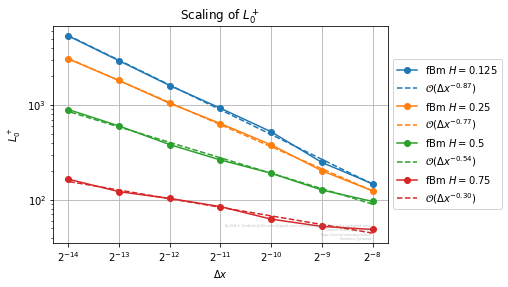

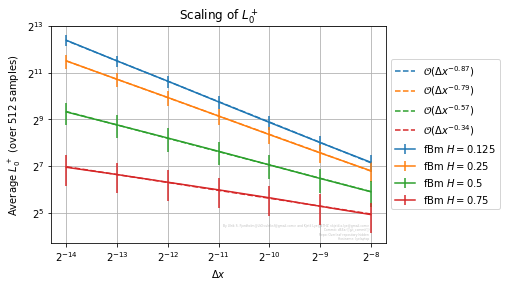

In [32]:
def run_lipschitz_resolution(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

    
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        plot_lipschitz_resolution(base_xml, name, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
    plt.figure(0)
    plot_info.legendLeft()
    plt.grid(True)
    plt.title("Scaling of $L^+_0$")
    plot_info.savePlot("fbm_lipschitz_scaling")
    
    plt.figure(1)
    plot_info.legendLeft()
    plt.grid(True)
    plt.title("Scaling of $L^+_0$")
    plot_info.savePlot("fbm_lipschitz_scaling_avg")
    plt.show()

run_lipschitz_resolution("burgers", "godunov", None, 0.1)

# TV scaling resolution

In [ ]:
def plot_tv_resolution(base_xml, title,  
                exact_solution_class=None,
                numerical_flux="rusanov",
                equation="burgers"):
    plot_info.console_log_show("Running plot TV over resolution for {},  flux={}, equation={}".format(base_xml,
                                                                                                numerical_flux,
                                                                                                equation))
    
    resolutions = 2**np.arange(START_CAUCHY_DET_T0_LOG, END_CAUCHY_DET_T0_LOG)
    delta_xs = 1.0 / resolutions
    TVs = []
    for r in resolutions:
        run = alsvinn.run(name="tv_resolution",
            base_xml=base_xml,
            number_of_saves=1,
            dimension=[r,1,1],
            flux=numerical_flux,
            equation=equation,
            uq=True, # notice that since we have Brownian initial data, we need to enable uq
            T=0.0000001)
        
        u0 = run.get_data('u', 0)
        TV = np.sum(abs(np.diff(u0)))
        TVs.append(TV)

    
    poly = np.polyfit(np.log(delta_xs), np.log(TVs), 1)
    
    line_information = plt.loglog(delta_xs, TVs, '-o', label=title)
    plt.loglog(delta_xs, np.exp(poly[1])*delta_xs**poly[0], '--', 
               color=line_information[0].get_color(),
              label='$\\mathcal{O}(\\Delta x^{%.2f})$' % poly[0], 
              basex=2)
    
    plt.xlabel('$\\Delta x$')
    plt.ylabel('$\\mathrm{TV}(u_0^{\\Delta x})$')
    plot_info.console_log_show("Done configuration {} {} {}".format(base_xml, equation, numerical_flux))

In [ ]:
def run_tv_resolution(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

    
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        plot_tv_resolution(base_xml, name, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
    plot_info.legendLeft()
    plt.title("Scaling of $\\mathrm{TV}(u_0^{\\Delta x})$")
    plt.grid(True)
    plot_info.savePlot("fbm_tv_scaling")
    
    plt.show()

run_tv_resolution("burgers", "godunov", None, 0.1)

# Lipschitz over time

In [33]:
def lipschitz_versus_time(base_xml, title, T, 
                    exact_solution_class=None,
                    numerical_flux="rusanov",
                    equation="burgers"):
    
    plot_info.console_log_show("Running lipschitz over time for {}, T={}, flux={}, equation={}".format(base_xml,
                                                                                                 T,
                                                                                                numerical_flux,
                                                                                                equation))
    N = 128
    M = CONVERGENCE_UQ_HIGHEST_RESOLUTION
    M_samples = NUMBER_OF_SAMPLES
    
    run = alsvinn.run(name="Lipschitz_solution",
        base_xml=base_xml,
        number_of_saves=N,
        dimension=[M,1,1],
        flux=numerical_flux,
        equation=equation,
        samples=M_samples,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    lipschitzs = []
    lipschitzs_avg = []
    Ts = np.linspace(0,T,N)
    for t_index in range(N):
        u = run.get_data("u", t_index)
        
        lipschitz = max((np.diff(u)>0)*np.diff(u))*M
        lipschitzs.append(lipschitz)
        
        avg = 0
        for k in range(M_samples):
            u = run.get_data("u", t_index, sample=k)
        
            lipschitz = max((np.diff(u)>0)*np.diff(u))*M
            avg += lipschitz
        avg /= M_samples
        lipschitzs_avg.append(avg)
        
    lipschitzs_avg = np.array(lipschitzs_avg)
    lipschitzs = np.array(lipschitzs)
    
    plt.figure(0)
    poly = np.polyfit(Ts[1:], 1.0/lipschitzs[1:], 1)
    
    print(poly)
    
    line_info = plt.plot(Ts, 1.0/lipschitzs, label=title)
    
    plt.plot(Ts[1:], poly[0]*Ts[1:]+poly[1],
             '--',
             color=line_info[0].get_color(),
             label='$%.3f t %+.3f$' % (poly[0], poly[1]))
    plt.title("T = {}".format(T))
    plot_info.legendLeft()
    plt.xlabel("$t^n$")
    plt.ylabel("$L^+_n$")
    
    
    plt.figure(1)
    poly = np.polyfit(Ts[1:], 1.0/lipschitzs_avg[1:], 1)
    
    print(poly)
    
    line_info = plt.plot(Ts, 1.0/lipschitzs_avg, label=title)
    
    plt.plot(Ts[1:], poly[0]*Ts[1:]+poly[1],
             '--',
             color=line_info[0].get_color(),
             label='$%.3f t %+.3f$' % (poly[0], poly[1]))
    plt.title("T = {}".format(T))
    plot_info.legendLeft()
    plt.xlabel("$t^n$")
    plt.ylabel("$L^+_n$ (averaged over %d samples)" % M_samples)
    plot_info.console_log_show("Done configuration {} {} {} {}".format(base_xml, equation, numerical_flux, T))


In [ ]:
def run_fbm_lipschitz_time(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

   
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        lipschitz_versus_time(base_xml, name, T, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
    plt.figure(0)
    plt.title("$L^+_n$ as a function of time,\nEquation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_lipschitz_time_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    plt.figure(1)
    plt.title("$L^+_n$ as a function of time,\nEquation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_lipschitz_time_avg_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    plt.show()
    
T = 0.5
run_all_configurations(run_fbm_lipschitz_time, T)
                                          

# Single solution compare

In [ ]:
def plot_solution_at_two_resolutions(base_xml, title, T, M1, M2, 
                exact_solution_class=None,
                numerical_flux="rusanov",
                equation="burgers"):
    
    
    
    plot_info.console_log_show("Running plot_solution_at_two_resolutions for {}, T={}, flux={}, equation={}".format(base_xml,
                                                                                                 T,
                                                                                                numerical_flux,
                                                                                                equation))
    run_m1 = alsvinn.run(name="M1solution",
        base_xml=base_xml,
        number_of_saves=1,
        dimension=[M1,1,1],
        flux=numerical_flux,
        equation=equation,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    
    run_m2 = alsvinn.run(name="M2solution",
        base_xml=base_xml,
        number_of_saves=1,
        dimension=[M2,1,1],
        flux=numerical_flux,
        equation=equation,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    t_indices = [0, 1]
    ts = [0, T]
    for t_index in t_indices:
        t = ts[t_index]
        u1 = run_m1.get_data("u", t_index)
        x1 = np.linspace(0, 1, u1.shape[0])
        
        u2 = run_m2.get_data("u", t_index)
        x2 = np.linspace(0, 1, u2.shape[0])
        
        plt.figure(t_index)
        plt.plot(x1, u1, label='$\\Delta x = 2^{-%d}$' % int(np.log2(M1)))
        plt.plot(x2, u2, label='$\\Delta x = 2^{-%d}$' % int(np.log2(M2)))
        plt.xlabel("$x$")
        plt.ylabel("$u(x,{})$".format(t))
        
    plot_info.console_log_show("Done configuration {} {} {} {}".format(base_xml, equation, numerical_flux, T))

In [ ]:
def run_fbm_plot_compare(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'

    M1 = COMPUTATIONAL_BUDGET
    M2 = 256
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        plot_solution_at_two_resolutions(base_xml, name, T, M1, M2, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
        plt.figure(0)
        plt.title("Comparing resolutions, $\\Delta x_1={dx1}, \\Delta x_2={dx2}$ ({M1} and {M2} cells),\nInitial data, fBm with $H={hurz}$\nEquation: {equation}, Numerical flux: {numerical_flux}"\
              .format(hurz=H, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(),
                      dx1=1.0/M1, dx2=1.0/M2, M1=M1, M2=M2))
        plot_info.legendLeft()
        plot_info.savePlot("fbm_initial_compare_{equation}_{H}_{numerical_flux}"
                .format(equation=equation, H=str(H).replace(".", "_"), numerical_flux=numerical_flux))
        
        plt.figure(1)
        plt.title("Comparing resolutions, $\\Delta x_1={dx1}, \\Delta x_2={dx2}$ ({M1} and {M2} cells),\nEvolved data at $T={T}$, initial data fBm with $H={hurz}$\nEquation: {equation}, Numerical flux: {numerical_flux}"\
              .format(hurz=H, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), 
                      T=T, dx1=1.0/M1, dx2=1./M2, M1=M1, M2=M2))
        plot_info.legendLeft()
                        
        plot_info.savePlot("fbm_evolved_compare_{equation}_{numerical_flux}_{T}_{H}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_"),
                        H=str(H).replace(".", "_")))
        plt.show()
        
for T in [1/256., 1]:
    run_all_configurations(run_fbm_plot_compare, T)

In [4]:
def run_average_convergence(base_xml, title, T, number_of_samples,
                    exact_solution_class=None,
                    numerical_flux="rusanov",
                    equation="burgers"):
    
    plot_info.console_log_show("Running run_average_convergence for {}, T={}, flux={}, equation={}".format(base_xml,
                                                                                                 T,
                                                                                                numerical_flux,
                                                                                                equation))

    resolutions = 2**np.arange(START_CONVERGENCE_UQ_LOG, END_CONVERGENCE_UQ_LOG+2)
    errors = []
    errors_max = []
    errors_min = []
    errors_var = []
    
    
    
    ## Make sample solution
    sample_solution_run = alsvinn.run(name="sample_solution",
        base_xml=base_xml,
        number_of_saves=1,
        dimension=[SAMPLE_SOLUTION_FACTOR*resolutions[-1],1,1],
        flux=numerical_flux,
        equation=equation,
        samples = number_of_samples,
        uq=True, # notice that since we have Brownian initial data, we need to enable uq
        T=T)
    
    
    
    
    ## Loop over resolutions
    for r in resolutions:
        ## Just some progress output, can be deleted
        sys.stdout.write("Resolution = {}\r".format(r))
        sys.stdout.flush()
        
        ## This is where we run alsvinn for the given resolution
        run = alsvinn.run(name="convergence_run",
                         base_xml=base_xml,
                         number_of_saves=1,
                         dimension=[r,1,1],
                         flux=numerical_flux,
                         equation=equation,
                         samples = number_of_samples,
                         uq=True, # notice that since we have Brownian initial data, we need to enable uq
                         T=T)
        errors_at_resolutions = []

        for sample in range(number_of_samples):
            if exact_solution_class is None:
                sample_solution = sample_solution_run.get_data("u", 1,sample=sample)
            else:
                initial_data = sample_solution_run.get_data("u", 0,sample=sample)
    
                exact_solution_object = exact_solution_class(initial_data)
        
                sample_solution = exact_solution_object(T)
        
            r_sample = sample_solution.shape[0]
        
            u_approx = run.get_data("u", 1, sample=sample)
        
            u_approx_upscaled = np.repeat(u_approx, r_sample//r)
        
            ## Compute L^1 error
            errors_at_resolutions.append(np.sum(abs(u_approx_upscaled-sample_solution))/r_sample)
        errors.append(np.mean(errors_at_resolutions))
        errors_max.append(max(errors_at_resolutions))
        errors_min.append(min(errors_at_resolutions))
        errors_var.append(np.var(errors_at_resolutions))
    errors = np.array(errors)
    errors_var=np.array(errors_var)
    sys.stdout.write("\r")
    plt.figure(0)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.errorbar(resolutions, errors, yerr=np.sqrt(errors_var),
                           label=title, barsabove=True)
    plt.gca().set_xscale("log", nonposx='clip',basex=2)
    plt.gca().set_yscale("log", nonposy='clip',basey=2)

    plt.grid(True)
    
    poly = np.polyfit(np.log(resolutions), np.log(errors), 1)
    plt.loglog(resolutions, np.exp(poly[1])*resolutions**poly[0], '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(M^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    
    
    plt.xlabel("Number of cells ($M$)")
    plt.ylabel("Expectation of Error ($\\mathbb{E}(||\\cdot||_{L^1([0,1])})$)")
    plt.legend()
    
    
    plt.figure(1)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.errorbar(1.0/resolutions, errors, yerr=np.sqrt(errors_var),
                           label=title, barsabove=True)
    plt.grid(True)
    
    poly = np.polyfit(np.log(1.0/resolutions), np.log(errors), 1)
    plt.loglog(1.0/resolutions, np.exp(poly[1])*resolutions**(-poly[0]), '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(\\Delta x^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    plt.xlabel("$\\Delta x$")
    plt.ylabel("Expectation of Error ($\\mathbb{E}(||\\cdot||_{L^1([0,1])})$)")
    plt.legend()
    
    
    plt.figure(2)
    ## Plot results, enable basex=2 to get nicer x axis
    line_info = plt.errorbar(1.0/resolutions, errors,  yerr=np.sqrt(errors_var),
                           label=title, barsabove=True)
    plt.grid(True)
    
    poly = np.polyfit(np.log(1.0/resolutions), np.log(-errors/np.log(1/resolutions)), 1)
    plt.loglog(1.0/resolutions, -np.log(1/resolutions)*np.exp(poly[1])*resolutions**(-poly[0]), '--', 
               color=line_info[0].get_color(), 
               label='$\\mathcal{O}(-\\log(\\Delta x)\\Delta x^{%.2f})$' % poly[0],
              basex=2, basey=2)
    plt.legend()
    
    plt.xlabel("$\\Delta x$")
    plt.ylabel("Expectation of Error ($\\mathbb{E}(||\\cdot||_{L^1([0,1])})$)")
    plt.legend()
   

   
    
    
    
    
    
    plot_info.console_log_show("Done configuration {} {} {} {}".format(base_xml, equation, numerical_flux, T))
    
        

In [ ]:
def run_fbm_average_convergence(equation, numerical_flux, exact_solution, T):
    Hs = [0.125, 0.25, 0.5, 0.75]

    base_xml_format_string = '../configs/fractional_brownian_{H_filename}/fractional_brownian.xml'
    number_of_samples = NUMBER_OF_SAMPLES
   
    for H in Hs:
        base_xml = base_xml_format_string.format(H_filename = str(H).replace(".","_"))
        
        name = "fBm $H={H}$".format(H=H)
        
        run_average_convergence(base_xml, name, T, number_of_samples, numerical_flux=numerical_flux,
                   equation=equation, exact_solution_class=exact_solution)
        
    plt.figure(0)
    plt.title("Average error over an ensemble of {number_of_samples} samples,\nEquation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(equation=equation.capitalize(), number_of_samples=number_of_samples, numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_avg_convergence_M_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    
    plt.figure(1)
    plt.title("Average error over an ensemble of {number_of_samples} samples,\n Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(number_of_samples=number_of_samples, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_avg_convergence_dx_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    
    plt.figure(2)
    plt.title("Average error over an ensemble of {number_of_samples} samples,\n Equation: {equation}, Numerical flux: {numerical_flux}, T = {T}"\
              .format(number_of_samples=number_of_samples, equation=equation.capitalize(), numerical_flux=numerical_flux.capitalize(), T=T))
    
    
    plot_info.legendLeft()
    plot_info.savePlot("fbm_avg_convergence_log_dx_{equation}_{numerical_flux}_{T}"
                .format(equation=equation, numerical_flux=numerical_flux, 
                        T=str(T).replace(".", "_")))
    
    plt.show()
    
for T in [1/2048., 1/256., 1/8, 1.0/4, 1]:
    run_all_configurations(run_fbm_average_convergence, T)
                                             

2019-04-05 14:15:06.960912 (in run_average_convergence): Running run_average_convergence for ../configs/fractional_brownian_0_125/fractional_brownian.xml, T=0.00048828125, flux=rusanov, equation=burgers
